### Evaluation Metrics for Classification

##### Evaluation metrics

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [4]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [79]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.pop('churn').values
y_val = df_val.pop('churn').values
y_test = df_test.pop('churn').values

In [6]:
categorical = list(categorical_columns)
categorical.remove('customerid')
categorical.remove('totalcharges')
categorical.remove('churn')
categorical.append('seniorcitizen')

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'seniorcitizen']

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

#### Accuracy and dummy model

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [12]:
thresholds = np.linspace(0, 1, 21)

scores = []

for threshold in thresholds:
    score = accuracy_score(y_val, y_pred >= threshold)
    print('%.2f %.3f' % (threshold, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


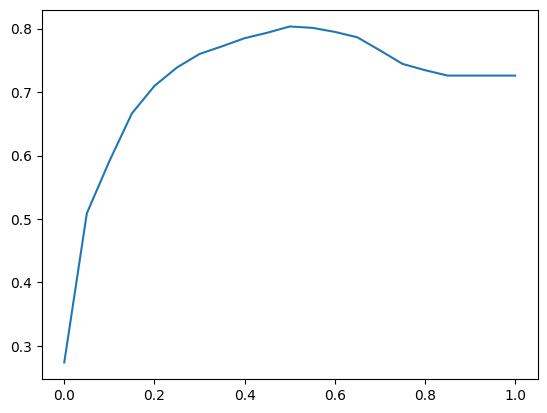

In [13]:
plt.plot(thresholds, scores)

In [14]:
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [15]:
1 - y_val.mean()

0.7260468417317246

#### 4.3 Confusion table

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [19]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [20]:
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

#### Precision and Recall

In [21]:
precision = tp / (tp + fp)

recall = tp / (tp + fn)

precision, recall

(0.6752411575562701, 0.5440414507772021)

ROC Curves (Receiver operating characteristics)

In [22]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

tpr, fpr

(0.5440414507772021, 0.09872922776148582)

In [23]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [24]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn) # true positive rate
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn) # false positive rate

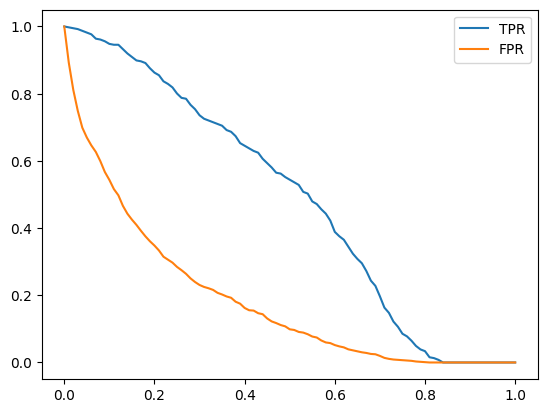

In [25]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

#### Random model

In [26]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [27]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [28]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [29]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

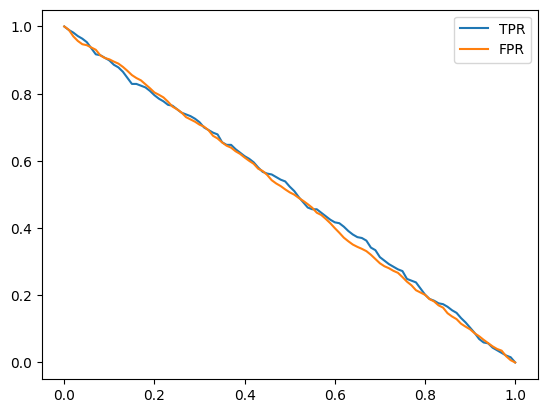

In [30]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

#### Ideal model

In [31]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [32]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [33]:
1 - y_val.mean()

0.7260468417317246

In [34]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [35]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


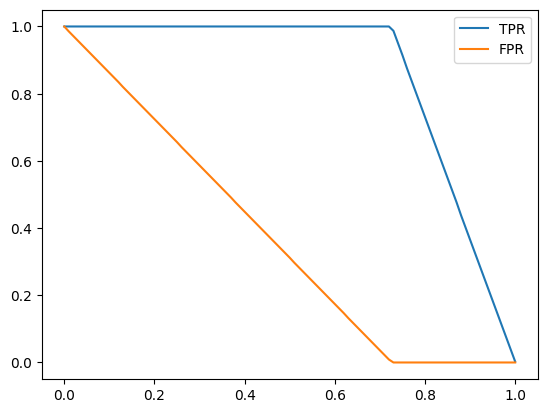

In [36]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

#### Putting everything together

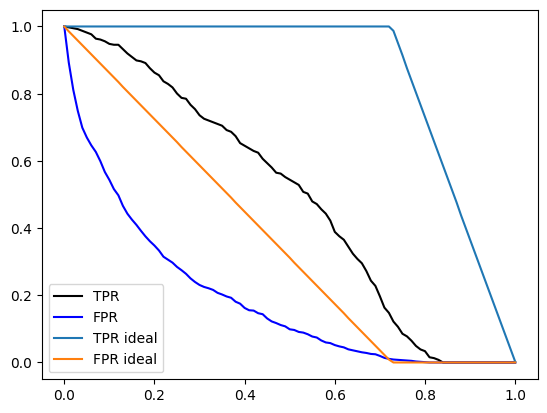

In [37]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

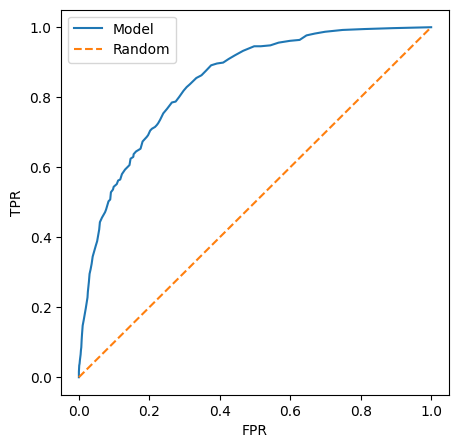

In [38]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

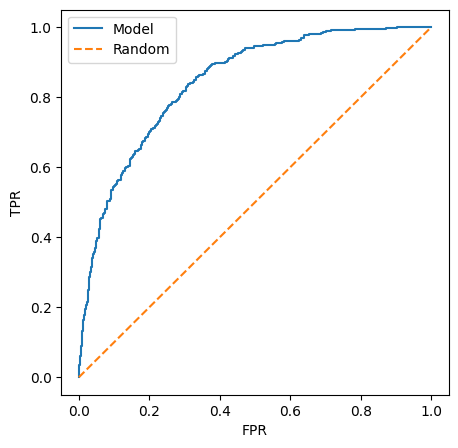

In [55]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

#### ROC AUC

In [41]:
from sklearn.metrics import auc

In [42]:
auc(fpr, tpr)

0.8438099868820244

In [43]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

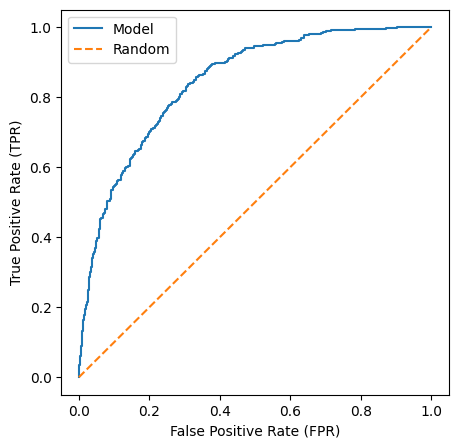

In [49]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle ='--')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

plt.legend()

#### ROC AUC

* Area under the ROC curve - useful metric
* Intepretation of AUC

In [50]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.8438099868820244

In [53]:
auc(df_scores.fpr, df_scores.tpr)

0.8438770962170594

In [56]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438099868820244

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438099868820244

In [59]:
neg = y_pred[y_val==0]
pos = y_pred[y_val==1]

In [60]:
from random import randint

success = 0
n = 100000

for i in range(n):
    pos_ind = randint(0, len(pos)- 1)
    neg_ind = randint(0, len(neg)- 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84227

In [61]:
n = 100000

np.random.seed(1)

pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84288

#### Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [62]:
from sklearn.feature_extraction import DictVectorizer
def train(df:pd.DataFrame, y:pd.Series, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y)

    return dv, model

In [63]:
dv, model = train(df_train, y_train, C=0.001)

In [66]:
def predict(df, dv, model):
    dicts = df[categorical+numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [68]:
y_pred = predict(df_val, dv, model)

In [70]:
from sklearn.model_selection import KFold
from tqdm import tqdm

In [80]:
import numpy as np
import numpy as np
import numpy as np
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores= [] # list to store accuracy for each fold

    for train_ind, val_ind in kfold.split(df_full_train):
        df_train, df_val = df_full_train.iloc[train_ind], df_full_train.iloc[val_ind]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model, train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C={C}, score=({np.mean(scores):.3f} +- {np.std(scores):.3f})')

 14%|█▍        | 1/7 [00:03<00:22,  3.81s/it]

C=0.001, score=(0.825 +- 0.010)


 29%|██▊       | 2/7 [00:14<00:39,  7.86s/it]

C=0.01, score=(0.825 +- 0.010)


 43%|████▎     | 3/7 [00:25<00:37,  9.45s/it]

C=0.1, score=(0.825 +- 0.010)


 57%|█████▋    | 4/7 [00:42<00:36, 12.20s/it]

C=0.5, score=(0.825 +- 0.010)


 71%|███████▏  | 5/7 [00:53<00:23, 11.96s/it]

C=1, score=(0.825 +- 0.010)


 86%|████████▌ | 6/7 [01:06<00:12, 12.05s/it]

C=5, score=(0.825 +- 0.010)


100%|██████████| 7/7 [01:17<00:00, 11.06s/it]

C=10, score=(0.825 +- 0.010)


In [81]:
scores

[0.8243478738686406,
 0.8328884419282214,
 0.8104274533413606,
 0.8206237609515892,
 0.8392072730695618]

In [83]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.8583300833089581